# <center>Urban Sound 8K - Features Analysis</center>

## Libraries Import

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import IPython
import datetime
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as transforms

## Import of the Metadata File

In [2]:
metadata = pd.read_csv("dataset/UrbanSound8K.csv")
metadata

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

## Audio Processing Parameters

In [3]:
target_length = 4
target_sample_rate = 22050
n_samples = target_length * target_sample_rate

## Selection of a Class

For a recall, the different classes present in the UrbanSound8K dataset are:
- air_conditioner
- car_horn
- children_playing
- dog_bark
- drilling
- engine_idling
- gun_shot
- jackhammer
- siren
- street_music

In [7]:
# Input annotations filtering critera
label = "street_music"
salience = 1 

# Filter annotations based on criteria
filtered_metadata = metadata.loc[
    (metadata["class"]==label)
    & (metadata["salience"]==salience)
    ]

# Randomly select an audio from the filtered annotations
selected_audio = filtered_metadata.sample(n=1) 
display(selected_audio)

slice_file_name   fsID  start  end  salience  fold  classID  \
8571  96475-9-0-6.wav  96475    3.0  7.0         1     2        9   

             class  
8571  street_music

In [8]:
for index, row in selected_audio.iterrows():
    audio_filename = row["slice_file_name"]
    audio_fold = f"fold{row['fold']}"
    audio_path = os.path.join("dataset", audio_fold, audio_filename)
    # Load the audio signal
    audio_signal, sr = torchaudio.load(audio_path)
    # Mix it down to mono if necessary
    if audio_signal.shape[0] > 1:
        audio_signal = torch.mean(audio_signal, dim=0, keepdim=True)
    # Resample it
    resample_transform = transforms.Resample(sr, target_sample_rate)
    audio_signal = resample_transform(audio_signal)
    # Cut if necessary
    if audio_signal.shape[1] > n_samples:
        audio_signal = audio_signal[:, :n_samples]
    # Right pad if necessary
    if audio_signal.shape[1] < n_samples:
        n_missing_samples = n_samples - audio_signal.shape[1]
        last_dim_padding = (0, n_missing_samples)
        audio_signal = nn.functional.pad(audio_signal, last_dim_padding)

## Sensitivity of Spectrogram to its Computation Parameters

### FFT Size

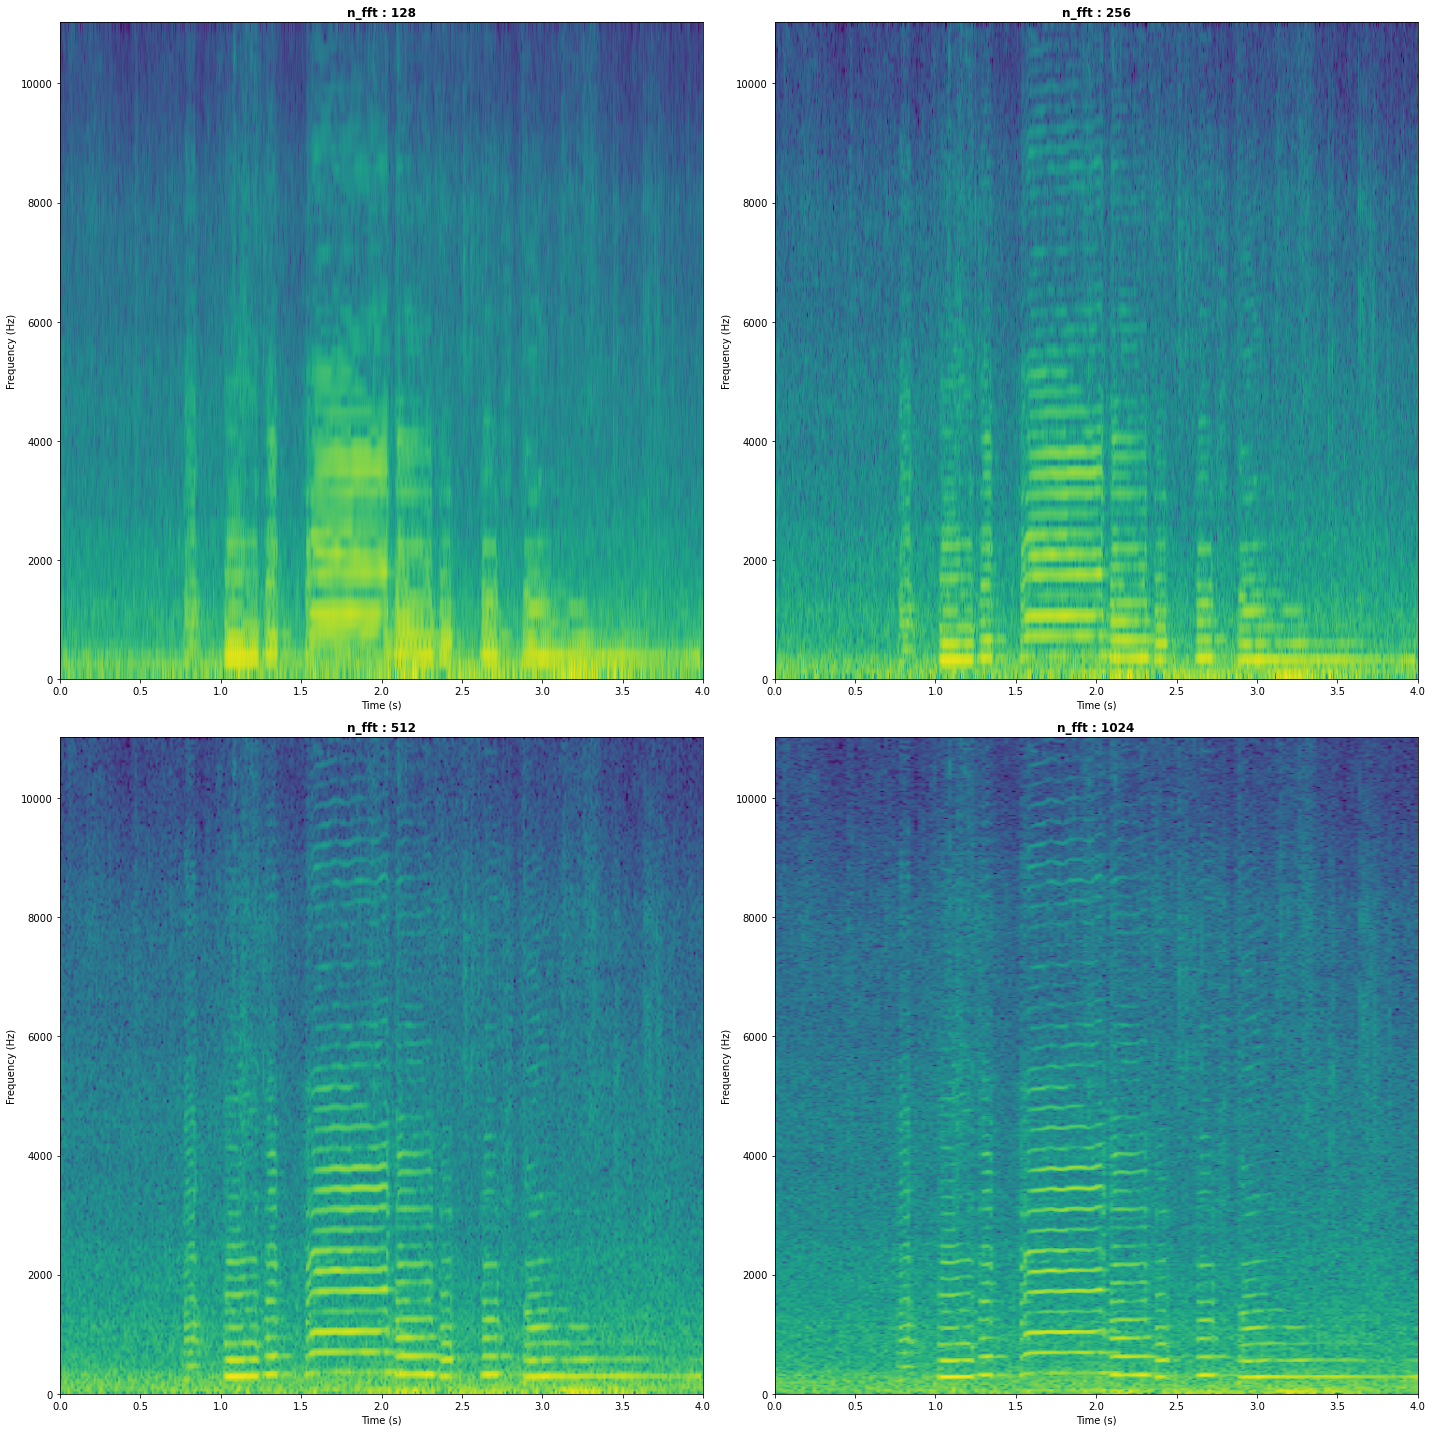

In [9]:
n_fft_values = [128, 256, 512, 1024]

n_cols = 2
n_rows = math.ceil(len(n_fft_values)/n_cols)

fig = plt.figure(figsize=(20,20))

amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB(
                    # Scale of input tensor ("power" or "magnitude"). The power being the elementwise square of the magnitude. (Default: "power")
                    stype = "power",
                    # Minimum negative cut-off in decibels. A reasonable number is 80. (Default: None)
                    top_db = None
                    )

for i, n_fft_value in enumerate(n_fft_values):
    
        spectrogram_transform = torchaudio.transforms.Spectrogram( 
                    # Size of FFT, creates n_fft // 2 + 1 bins. (Default: 400)
                    n_fft = n_fft_value,
                    # Window size. (Default: n_fft)
                    win_length = n_fft_value,
                    # Length of hop between STFT windows. (Default: win_length // 2)
                    hop_length = n_fft_value // 2,
                    # Two sided padding of signal. (Default: 0)
                    pad = 0,
                    # A function to create a window tensor that is applied/multiplied to each frame/window. (Default: torch.hann_window)
                    window_fn = torch.hann_window,
                    # Exponent for the magnitude spectrogram, (must be > 0) e.g., 1 for energy, 2 for power, etc. (Default: 2)
                    power = 2,
                    # Whether to normalize by magnitude after stft. (Default: False)
                    normalized = True,
                    # Arguments for window function. (Default: None)
                    wkwargs = None,
                    # Whether to pad waveform on both sides so that the t-th frame is centered at time t x hop_length (Default: True)
                    center = False,
                    # Controls the padding method used when center is True. (Default: "reflect")
                    pad_mode = "reflect",
                    # Controls whether to return half of results to avoid redundancy. (Default: True)
                    onesided = True,
                    # Indicates whether the resulting complex-valued Tensor should be represented with native complex dtype, 
                    # such as torch.cfloat and torch.cdouble, or real dtype mimicking complex value with an extra dimension 
                    # for real and imaginary parts. (See also torch.view_as_real.)
                    # This argument is only effective when power=None. It is ignored for cases where power is a number as in those cases, the returned tensor is power spectrogram, which is a real-valued tensor.
                    return_complex = False
                    )   
        
        num_channels, num_frames = audio_signal.shape
        time_axis = torch.arange(0, num_frames) / target_sample_rate
    
        spectrogram = torch.squeeze(spectrogram_transform(audio_signal)[0])
        spectrogram_db = amplitude_to_db_transform(spectrogram)
    
        n_fft_spec = (spectrogram_db.shape[0] - 1) * 2
        frequency = (target_sample_rate / n_fft_spec) * np.linspace(0, n_fft_spec/2, spectrogram_db.shape[0])
        max_frequency_bin = frequency.max()
    
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax.imshow(spectrogram_db, extent=[0, target_length, 0, target_sample_rate/2], origin="lower", aspect="auto")
        ax.set_title(f"n_fft : {n_fft_value}", fontweight="bold", fontsize=12)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time (s)")
        
plt.tight_layout()
plt.show()

### Hop Length

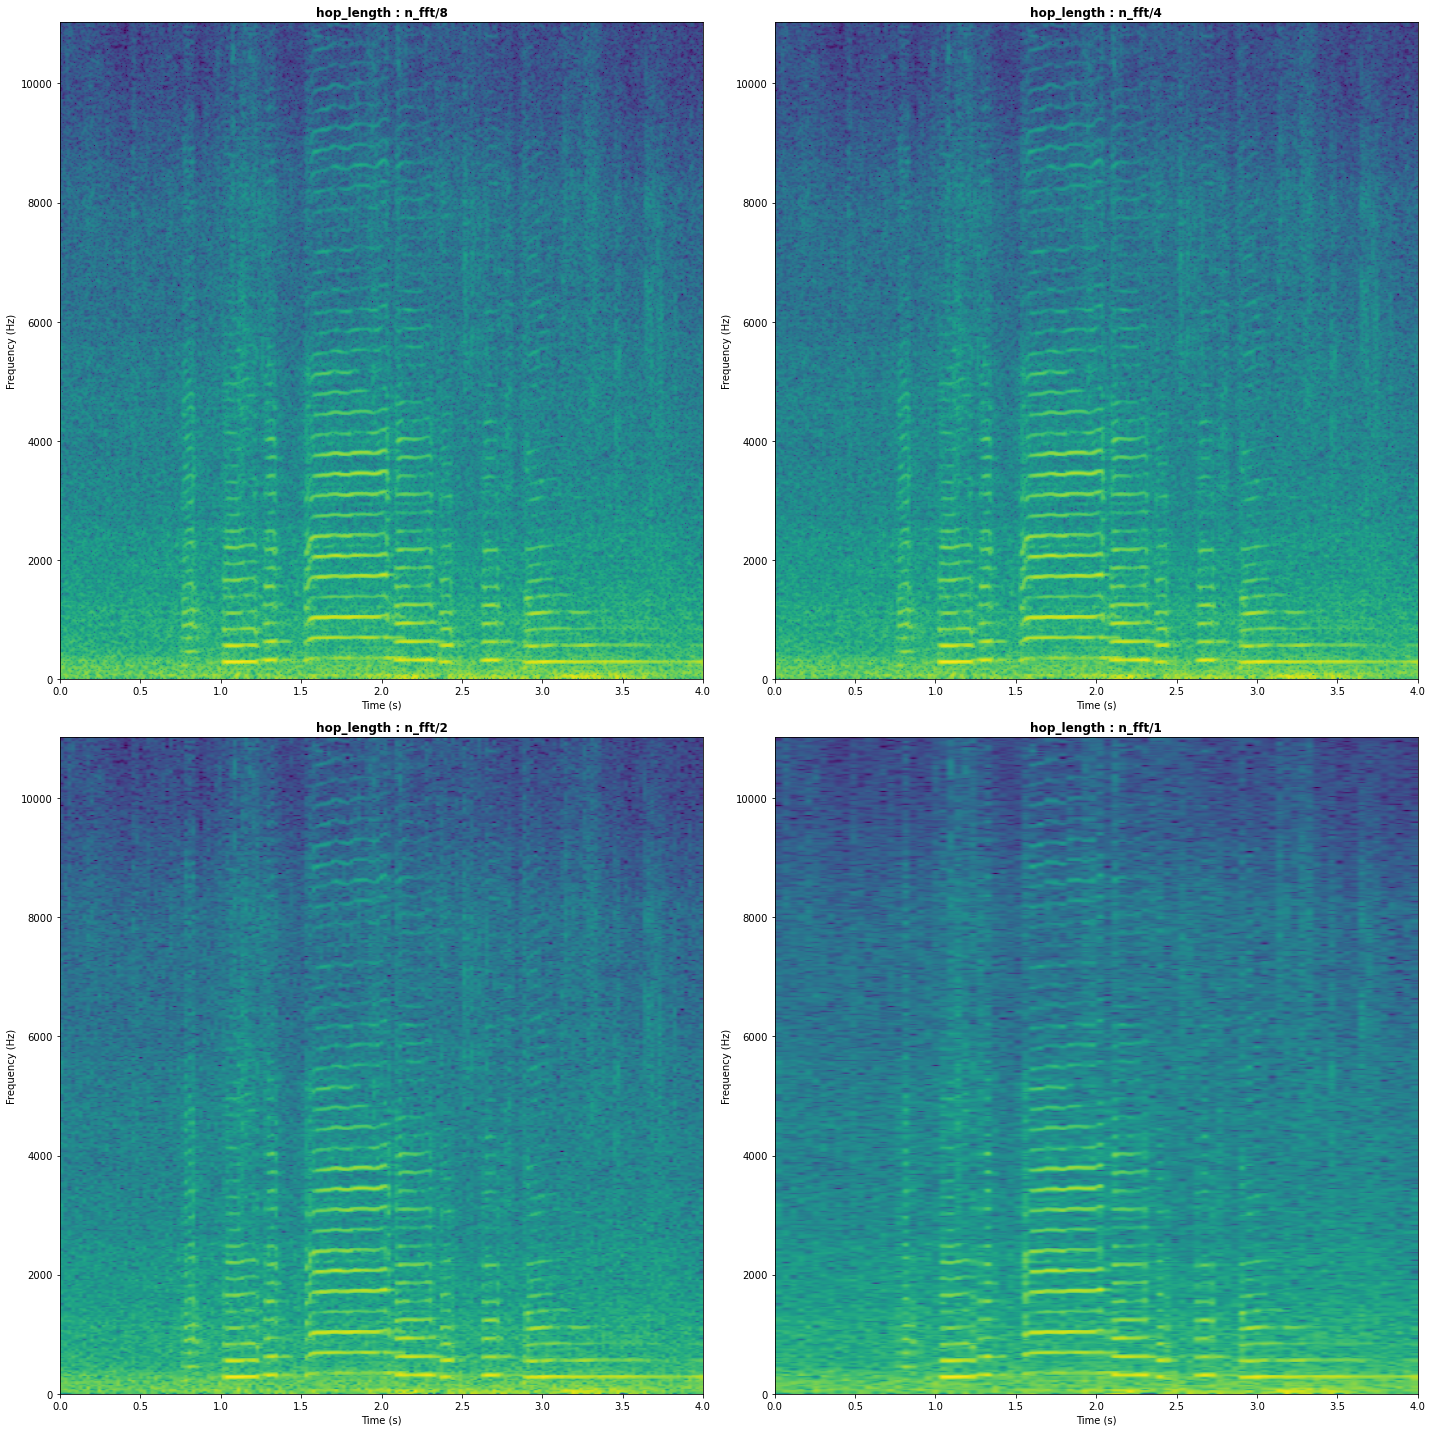

In [11]:
hop_length_divisors = [8, 4, 2, 1]

n_cols = 2
n_rows = math.ceil(len(hop_length_divisors)/n_cols)

fig = plt.figure(figsize=(20,20))

amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB(
                    # Scale of input tensor ("power" or "magnitude"). The power being the elementwise square of the magnitude. (Default: "power")
                    stype = "power",
                    # Minimum negative cut-off in decibels. A reasonable number is 80. (Default: None)
                    top_db = None
                    )

for i, hop_length_divisor in enumerate(hop_length_divisors):
    
        spectrogram_transform = torchaudio.transforms.Spectrogram( 
                    # Size of FFT, creates n_fft // 2 + 1 bins. (Default: 400)
                    n_fft = 1024,
                    # Window size. (Default: n_fft)
                    win_length = 1024,
                    # Length of hop between STFT windows. (Default: win_length // 2)
                    hop_length = 1024 // hop_length_divisor,
                    # Two sided padding of signal. (Default: 0)
                    pad = 0,
                    # A function to create a window tensor that is applied/multiplied to each frame/window. (Default: torch.hann_window)
                    window_fn = torch.hann_window,
                    # Exponent for the magnitude spectrogram, (must be > 0) e.g., 1 for energy, 2 for power, etc. (Default: 2)
                    power = 2,
                    # Whether to normalize by magnitude after stft. (Default: False)
                    normalized = True,
                    # Arguments for window function. (Default: None)
                    wkwargs = None,
                    # Whether to pad waveform on both sides so that the t-th frame is centered at time t x hop_length (Default: True)
                    center = False,
                    # Controls the padding method used when center is True. (Default: "reflect")
                    pad_mode = "reflect",
                    # Controls whether to return half of results to avoid redundancy. (Default: True)
                    onesided = True,
                    # Indicates whether the resulting complex-valued Tensor should be represented with native complex dtype, 
                    # such as torch.cfloat and torch.cdouble, or real dtype mimicking complex value with an extra dimension 
                    # for real and imaginary parts. (See also torch.view_as_real.)
                    # This argument is only effective when power=None. It is ignored for cases where power is a number as in those cases, the returned tensor is power spectrogram, which is a real-valued tensor.
                    return_complex = False
                    )   
        
        num_channels, num_frames = audio_signal.shape
        time_axis = torch.arange(0, num_frames) / target_sample_rate
    
        spectrogram = torch.squeeze(spectrogram_transform(audio_signal)[0])
        spectrogram_db = amplitude_to_db_transform(spectrogram)
    
        n_fft_spec = (spectrogram_db.shape[0] - 1) * 2
        frequency = (target_sample_rate / n_fft_spec) * np.linspace(0, n_fft_spec/2, spectrogram_db.shape[0])
        max_frequency_bin = frequency.max()
    
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax.imshow(spectrogram_db, extent=[0, target_length, 0, target_sample_rate/2], origin="lower", aspect="auto")
        ax.set_title(f"hop_length : n_fft/{hop_length_divisor}", fontweight="bold", fontsize=12)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time (s)")
        
plt.tight_layout()
plt.show()

### Windowing Function

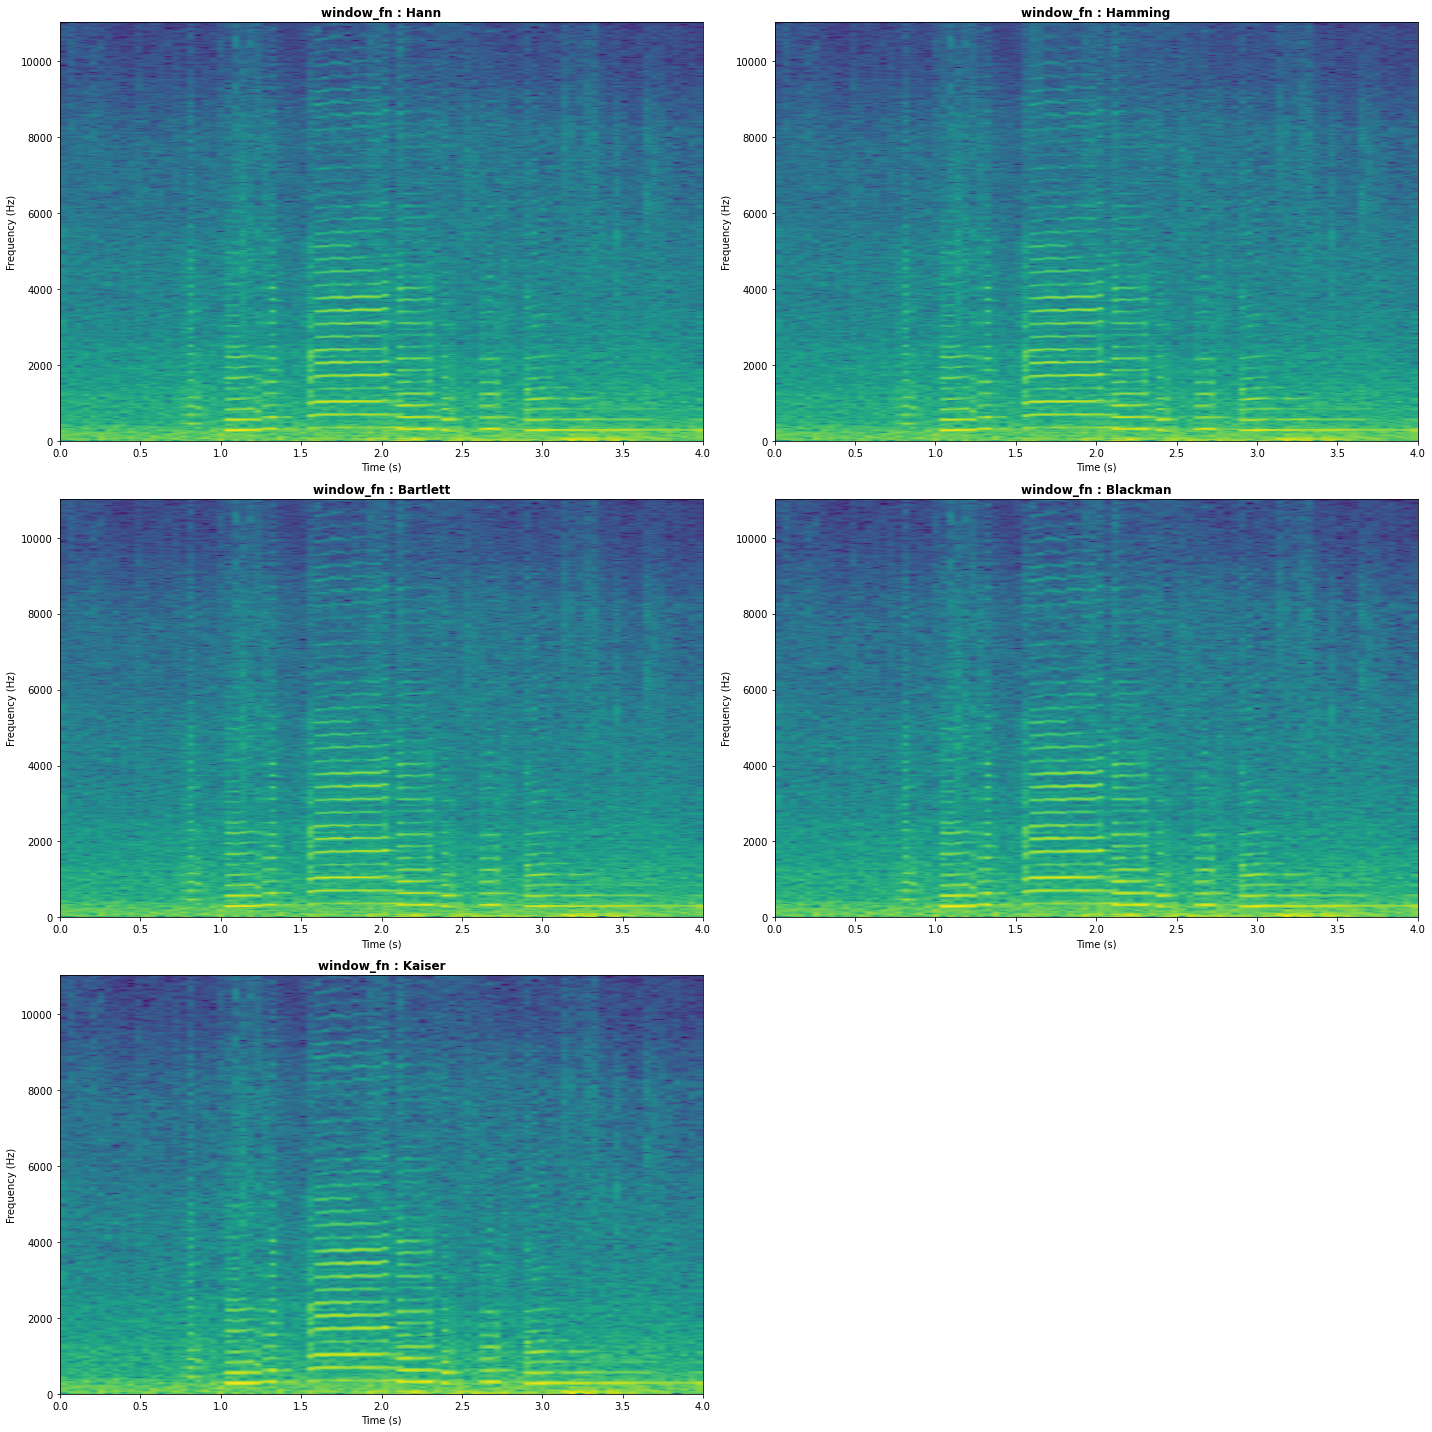

In [18]:
window_functions = {
    "Hann":torch.hann_window, 
    "Hamming":torch.hamming_window, 
    "Bartlett":torch.bartlett_window, 
    "Blackman":torch.blackman_window, 
    "Kaiser":torch.kaiser_window
}

n_cols = 2
n_rows = math.ceil(len(window_functions)/n_cols)

fig = plt.figure(figsize=(20,20))

amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB(
                    # Scale of input tensor ("power" or "magnitude"). The power being the elementwise square of the magnitude. (Default: "power")
                    stype = "power",
                    # Minimum negative cut-off in decibels. A reasonable number is 80. (Default: None)
                    top_db = None
                    )

for i, (window_name, window_function) in enumerate(window_functions.items()):
    
        spectrogram_transform = torchaudio.transforms.Spectrogram( 
                    # Size of FFT, creates n_fft // 2 + 1 bins. (Default: 400)
                    n_fft = 1024,
                    # Window size. (Default: n_fft)
                    win_length = 1024,
                    # Length of hop between STFT windows. (Default: win_length // 2)
                    hop_length = 1024 // hop_length_divisor,
                    # Two sided padding of signal. (Default: 0)
                    pad = 0,
                    # A function to create a window tensor that is applied/multiplied to each frame/window. (Default: torch.hann_window)
                    window_fn = window_function,
                    # Exponent for the magnitude spectrogram, (must be > 0) e.g., 1 for energy, 2 for power, etc. (Default: 2)
                    power = 2,
                    # Whether to normalize by magnitude after stft. (Default: False)
                    normalized = True,
                    # Arguments for window function. (Default: None)
                    wkwargs = None,
                    # Whether to pad waveform on both sides so that the t-th frame is centered at time t x hop_length (Default: True)
                    center = False,
                    # Controls the padding method used when center is True. (Default: "reflect")
                    pad_mode = "reflect",
                    # Controls whether to return half of results to avoid redundancy. (Default: True)
                    onesided = True,
                    # Indicates whether the resulting complex-valued Tensor should be represented with native complex dtype, 
                    # such as torch.cfloat and torch.cdouble, or real dtype mimicking complex value with an extra dimension 
                    # for real and imaginary parts. (See also torch.view_as_real.)
                    # This argument is only effective when power=None. It is ignored for cases where power is a number as in those cases, the returned tensor is power spectrogram, which is a real-valued tensor.
                    return_complex = False
                    )   
        
        num_channels, num_frames = audio_signal.shape
        time_axis = torch.arange(0, num_frames) / target_sample_rate
    
        spectrogram = torch.squeeze(spectrogram_transform(audio_signal)[0])
        spectrogram_db = amplitude_to_db_transform(spectrogram)
    
        n_fft_spec = (spectrogram_db.shape[0] - 1) * 2
        frequency = (target_sample_rate / n_fft_spec) * np.linspace(0, n_fft_spec/2, spectrogram_db.shape[0])
        max_frequency_bin = frequency.max()
    
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax.imshow(spectrogram_db, extent=[0, target_length, 0, target_sample_rate/2], origin="lower", aspect="auto")
        ax.set_title(f"window_fn : {window_name}", fontweight="bold", fontsize=12)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time (s)")
        
plt.tight_layout()
plt.show()